In this note book we want to build and train a GAN that can generate hand-written images of digits (0-9). 

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

Forst of all we have to make a function for visualizing images: Given a tensor of images, number of images, and size per image, plots and prints the images in a uniform grid.

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

### Generator

`Generator Block`

In [3]:
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )

`Generator Class`  
This class take 3 values:  

*   The noise vector dimension
*   The image dimension
*   The initial hidden dimension

Using these values, the generator will build a neural network with 5 layers/blocks. Beginning with the noise vector, the generator will apply non-linear transformations via the block function until the tensor is mapped to the size of the image to be outputted (the same size as the real images from MNIST).   

Finally, we are given a forward pass function that takes in a noise vector and generates an image of the output dimension using our neural network.

In [4]:
class Generator(nn.Module):

    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        return self.gen(noise)

`Noise`  
To be able to use our generator, we will need to be able to create noise vectors. The noise vector $z$ has the important role of making sure the images generated from the same class don't all look the same.


In [5]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim).to(device)

### Discriminator

`Discriminator Block`

In [6]:
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(negative_slope=0.2)
    )

`Discriminator Class`  
Now we can use these blocks to make a discriminator! The discriminator class holds 2 values:

*   The image dimension
*   The hidden dimension

The discriminator will build a neural network with 4 layers. It will start with the image tensor and transform it until it returns a single number (1-dimension tensor) output. This output classifies whether an image is fake or real. Finally, to use our discrimator's neural network we are given a forward pass function that takes in an image tensor to be classified.


In [7]:
class Discriminator(nn.Module):
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim,1)
        )

    def forward(self, image):
        return self.disc(image)

### Training  
Now we can put it all together!
First, we will set our parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times we iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   device: the device type, here using a GPU (which runs CUDA), not CPU

Next, we will load the MNIST dataset as tensors using a dataloader.


In [8]:
# Set our parameters
criterion = nn.BCEWithLogitsLoss()# Binary Cross Entropy
n_epochs = 20
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001
device = 'cpu'

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=False, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

Now, you can initialize your generator, discriminator, and optimizers. 

In [9]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

Before we train our GAN, we will need to create functions to calculate the discriminator's loss and the generator's loss. This is how the discriminator and generator will know how they are doing and improve themselves.  
Since the generator is needed when calculating the discriminator's loss, you will need to call `.detach()` on the generator result to ensure that only the discriminator is updated!

`Discriminator Loss Function`  
These are the some steps we will need to consider:
1) Create noise vectors and generate a batch (num_images) of fake images. 
2) Make sure to pass the device argument to the noise.
3) Get the discriminator's prediction of the fake image and detach the generator.
4) Calculate the loss. You need a 'ground truth' tensor in order to calculate the loss. ground truth tensor for a fake image is all zeros.
5) Get the discriminator's prediction of the real image.
6) Calculate the loss.  You need a 'ground truth' tensor in order to calculate the loss. Ground truth tensor for a fake image is all ones.
7) Calculate the discriminator's loss by averaging the real and fake loss
and set it to disc_loss.


In [10]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''   
    noise = get_noise(num_images, z_dim, device) #1
    fake_image = gen(noise) #2
    Disc_Fake = disc(fake_image.detach()) #3
    fake_labels = torch.zeros_like(Disc_Fake)  # Ground truth labels for fake images are all zeros
    Loss_Disc_Fake = criterion(Disc_Fake,fake_labels) #4
    Disc_Real = disc(real) #5
    real_labels = torch.ones_like(Disc_Real)  # Ground truth labels for fake images are all ones
    Loss_Disc_Real = criterion(Disc_Real,real_labels) #6
    disc_loss = (Loss_Disc_Real+Loss_Disc_Fake)/2 #7
    return disc_loss

`Generator Loss Function`  
Now we have to train the Generator  
These are the steps you will need to complete:
1) Create noise vectors and generate a batch of fake images. 
2) pass the device argument to the get_noise function.
3) Get the discriminator's prediction of the fake image.
4) Calculate the generator's loss. Remember the generator wantsthe discriminator to think that its fake images are real.


In [11]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    noise =get_noise(num_images,z_dim,device) #1
    fake_image = gen(noise) #2
    disc_pred = disc(fake_image) #3
    real_labels = torch.ones_like(disc_pred)  # Ground truth labels for fake images are all ones
    gen_loss = criterion(disc_pred,real_labels) #4
    return gen_loss

Now we can see what will happend and how `GAN` train our generator and discriminator

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 1.389885227322577, discriminator loss: 0.41950646847486467


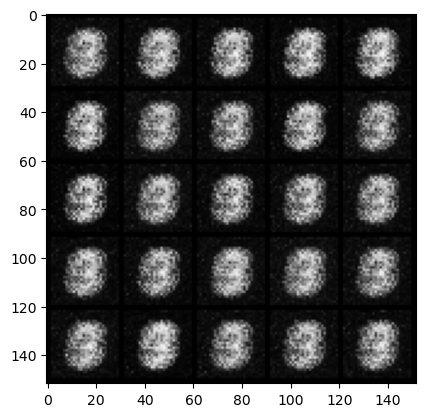

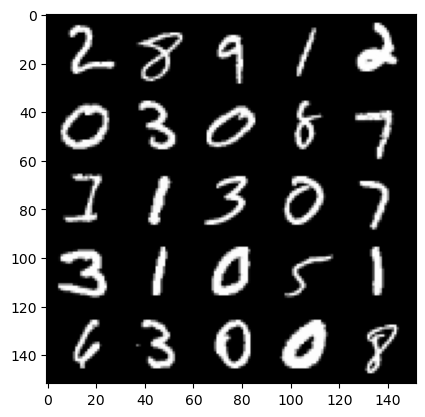

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.675175240039825, discriminator loss: 0.2989807033836841


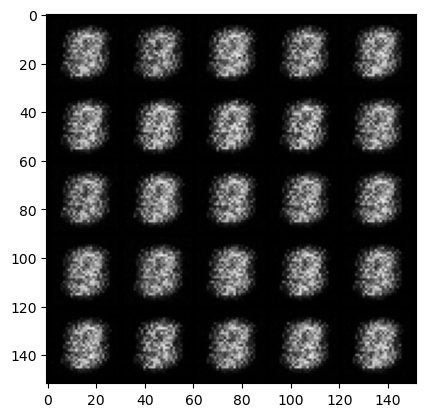

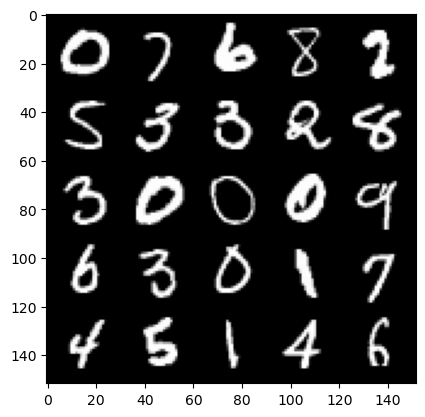

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 1.9659882836341835, discriminator loss: 0.1732797607779501


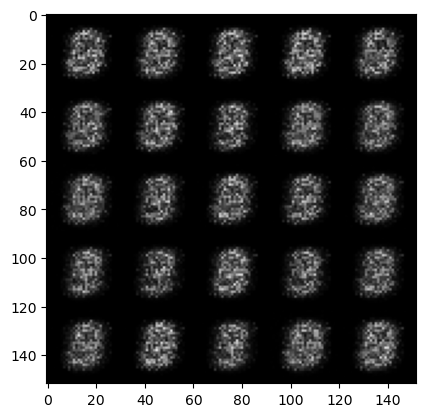

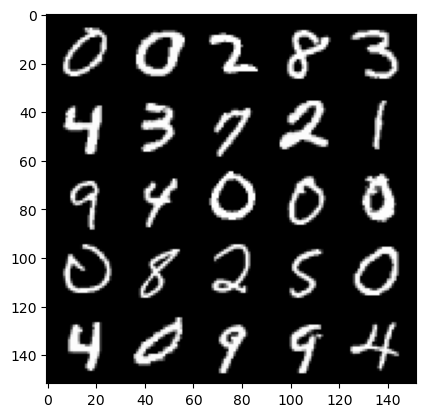

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.793409898757934, discriminator loss: 0.19062099671363827


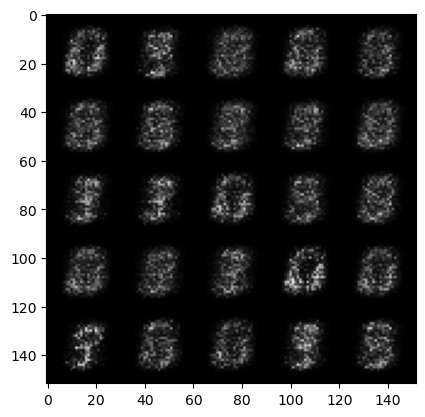

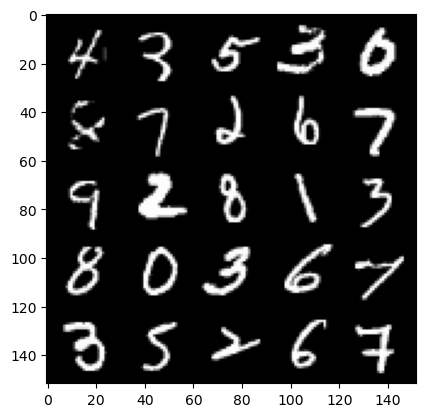

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 1.7320369901657087, discriminator loss: 0.19495249879360213


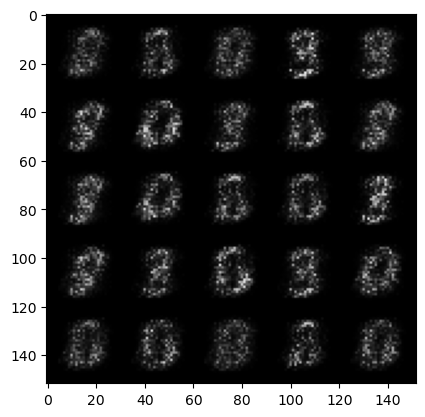

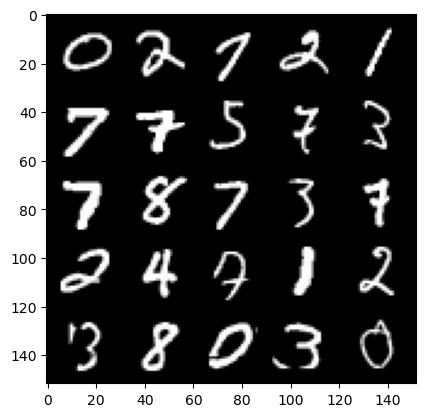

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 2.0336706779003166, discriminator loss: 0.14593421903252593


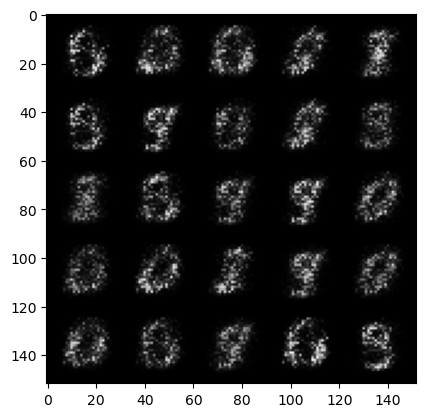

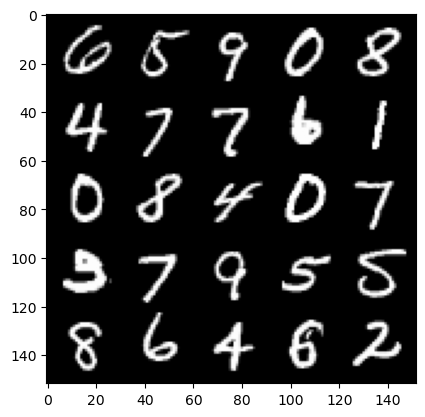

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 2.4586215906143183, discriminator loss: 0.12175850100815298


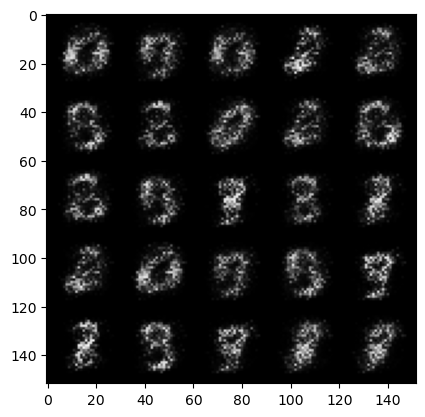

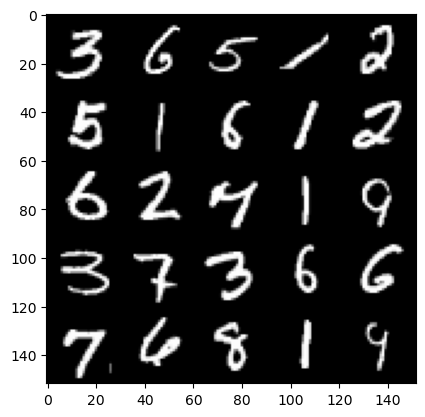

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 2.7290604505538925, discriminator loss: 0.11422181232273577


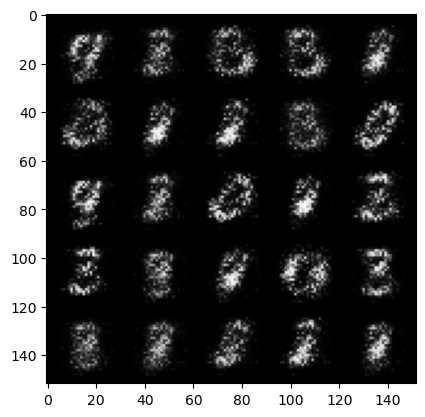

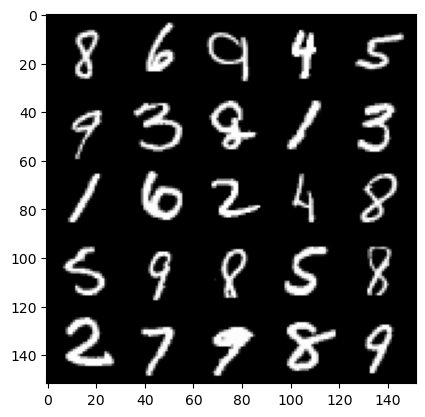

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 3.181794485092163, discriminator loss: 0.10685449559986604


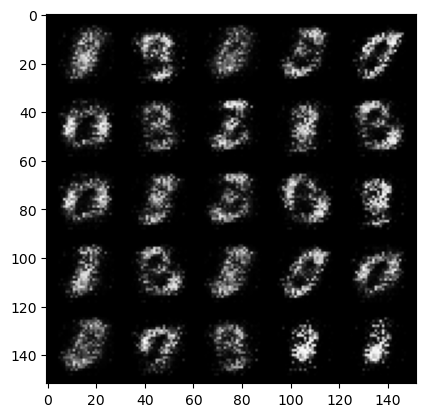

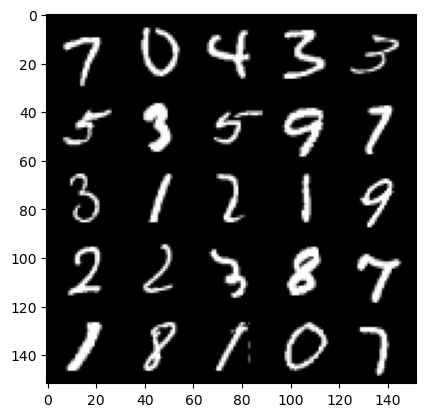

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 3.2491498231887777, discriminator loss: 0.08966029964387419


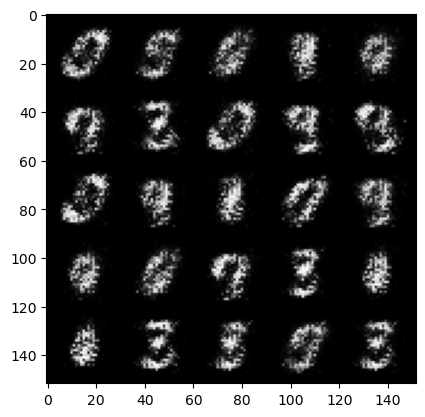

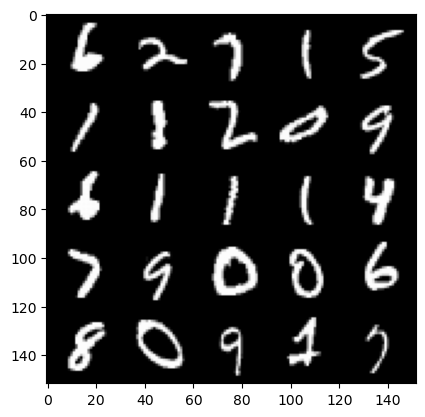

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 3.596860813140866, discriminator loss: 0.07894802294671535


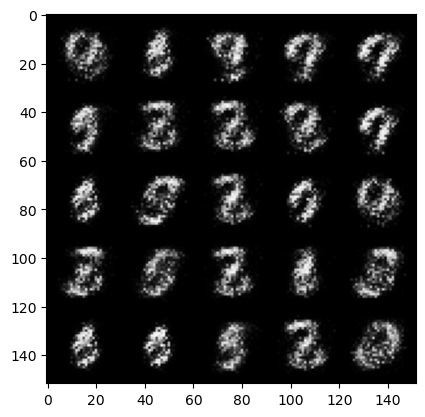

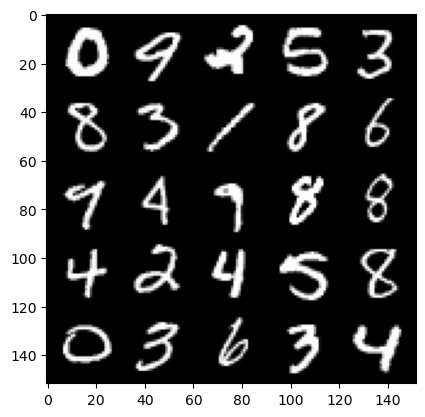

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 3.5900101661682156, discriminator loss: 0.08355552767962218


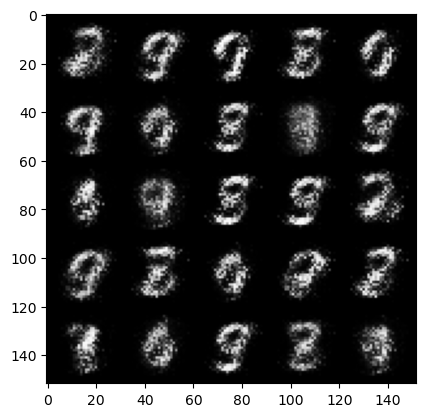

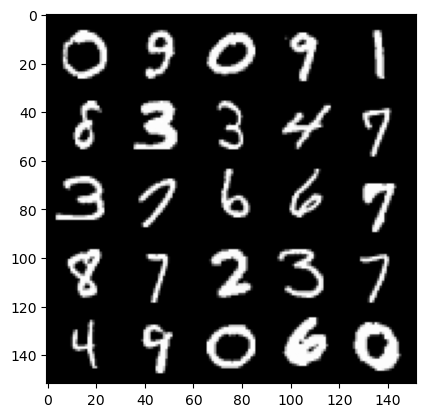

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 3.7781619610786428, discriminator loss: 0.06748028767853977


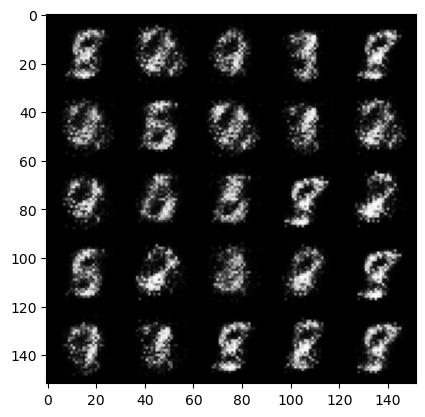

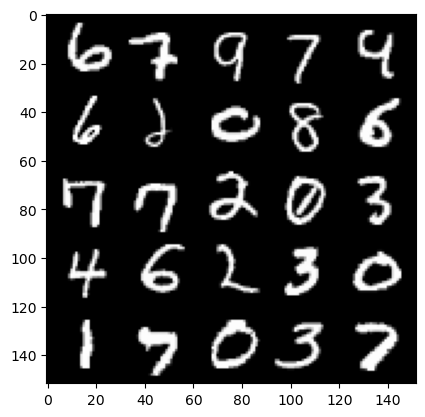

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 4.019988223075862, discriminator loss: 0.06437767671793693


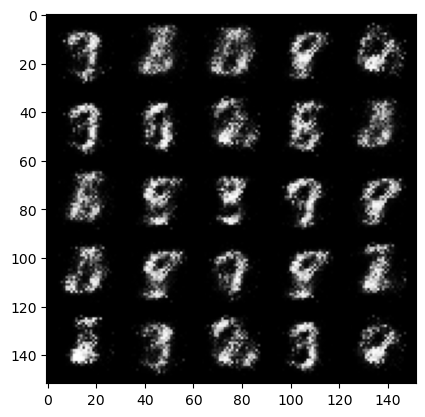

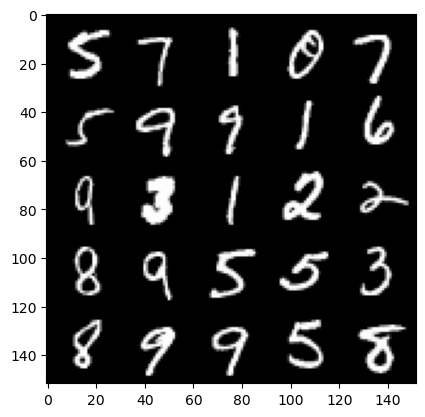

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 4.028244587421411, discriminator loss: 0.05934966706857086


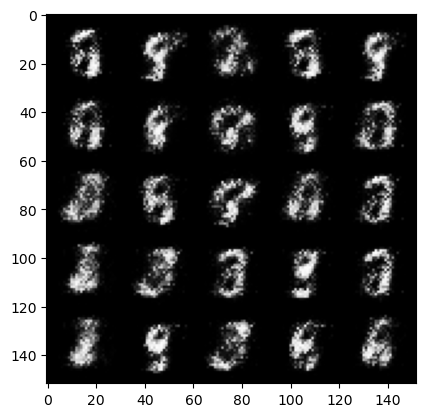

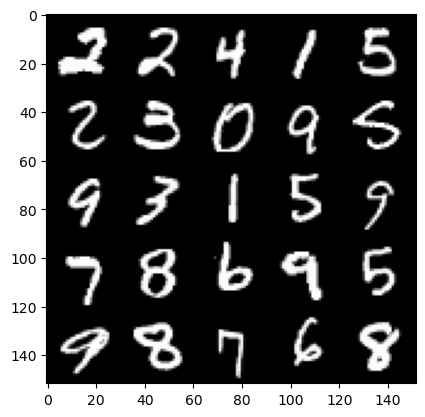

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 3.862276980876926, discriminator loss: 0.06336292571574453


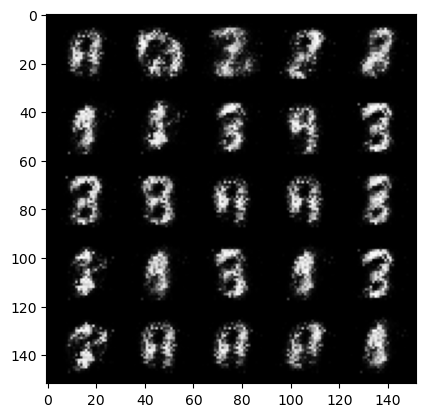

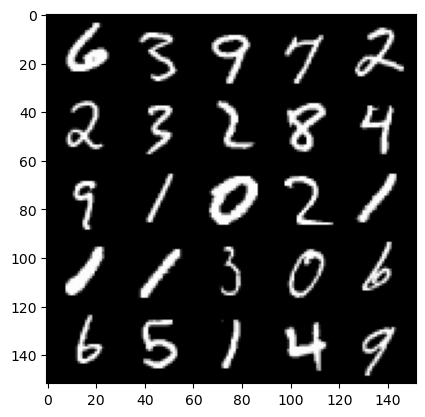

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 3.8566084799766545, discriminator loss: 0.06608505668118594


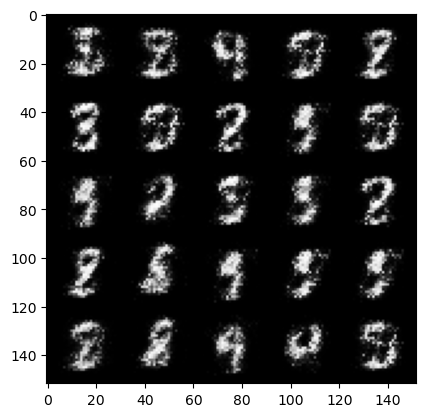

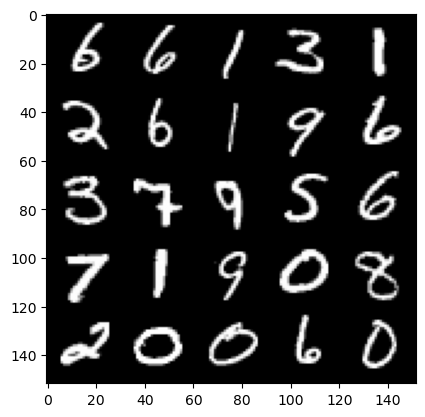

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 3.9967347779273967, discriminator loss: 0.05570170108228921


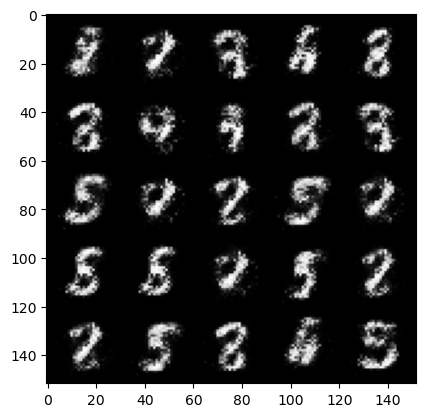

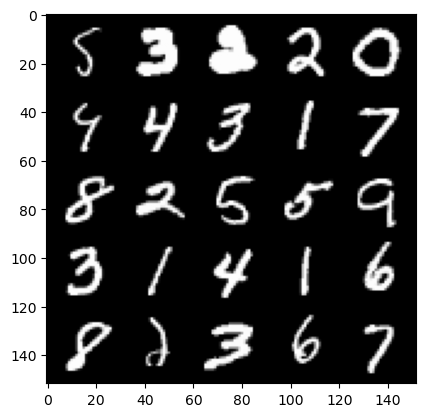

In [12]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()
        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        ### Update generator ###
        # Zero out the gradients 
        gen_opt.zero_grad()
        # Calculate the generator loss, assigning it to gen_loss.
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        # Backprop through the generator
        gen_loss.backward(retain_graph=True)
        # update the gradients and optimizer.
        gen_opt.step()

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
